In [1]:
!pip install pafy
!pip install youtube-dl

     |████████████████████████████████| 1.9 MB 12.9 MB/s 


In [2]:
import os
import cv2
import math
import pafy
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from moviepy.editor import *
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

import os
import glob
import keras
import gc


Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3760128/45929032 bytes (8.2%)7684096/45929032 bytes (16.7%)11763712/45929032 bytes (25.6%)15745024/45929032 bytes (34.3%)19816448/45929032 bytes (43.1%)23855104/45929032 bytes (51.9%)27975680/45929032 bytes (60.9%)32014336/45929032 bytes (69.7%)36052992/45929032 bytes (78.5%)40140800/45929032 bytes (87.4%)44236800/45929032 bytes (96.3%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root

In [3]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib as mpl  # EA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score
import time
import concurrent.futures 
from time import sleep
from multiprocess import Pool
import pandas as pd

In [4]:
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions)))) 

In [5]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(20,20))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

In [6]:
def plot_confusion_matrix_labeled(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    # define classes 
    classes = CLASSES_LIST
    temp_df = pd.DataFrame(data=mtx,columns=classes)
    temp_df.index = classes
    fig, ax = plt.subplots(figsize=(20,20))
    sns.heatmap(temp_df, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

In [7]:
def print_validation_report_labeled(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions, target_names= CLASSES_LIST))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions)))) 

In [ ]:
#!pip install keras-video-generators

In [ ]:
#from tensorflow.keras.utils import Sequence
#from keras_video import VideoFrameGenerator

In [15]:
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**step 1 load data**

In [ ]:
# !rm '/content/UCF50.rar'

In [ ]:
# !rm -r -f '/content/UCF50' 

In [ ]:
!wget -nc --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar
!unrar x UCF50.rar -inul -y

--2021-12-04 22:08:26--  https://www.crcv.ucf.edu/data/UCF50.rar
Resolving www.crcv.ucf.edu (www.crcv.ucf.edu)... 132.170.214.127
Connecting to www.crcv.ucf.edu (www.crcv.ucf.edu)|132.170.214.127|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 3233554570 (3.0G) [application/rar]
Saving to: ‘UCF50.rar’

UCF50.rar           100%[===================>]   3.01G  16.0MB/s    in 3m 17s  

2021-12-04 22:11:46 (15.7 MB/s) - ‘UCF50.rar’ saved [3233554570/3233554570]



In [ ]:
# data_root = '/content/gdrive/MyDrive/UCF50/'

In [ ]:
# os.mkdir(data_root)

In [ ]:
# !mv "/content/UCF50"    "/content/gdrive/MyDrive/UCF50"

In [ ]:
# !!cp -r "/content/gdrive/MyDrive/UCF50" "/content/" 

^C


[]

**Step 2: Visualize the Data with its Labels**

In [ ]:
  #  with open('/content/gdrive/MyDrive/classes.txt') as f:
  #   lines = f.readlines()

In [ ]:
# CLASSES_LIST =[]
# for i in lines:
#   i = i.replace(" ",'')
#   i= i.replace("\n","")
#   CLASSES_LIST.append(i)

In [33]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

# Specify the directory containing the UCF50 dataset. 
DATASET_DIR = "UCF50"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = sorted(list(os.listdir('/content/gdrive/MyDrive/UCF50')))
#["WalkingWithDog", "TaiChi", "Swing", "HorseRace"]

**Extract, Resize and Normalize Frames**

In [ ]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''
    
    # Declare a list to store video frames.
    frames_list =[] #np.array([])
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
    gc.collect()
    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video. 
        success, frame = video_reader.read() 
        gc.collect()

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
       
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        #video_reader.release()
        

        # Append the normalized frame into the frames list
        
        frames_list.append(normalized_frame)
    #     del(frame,resized_frame)
    #     gc.collect()
    # # Release the VideoCapture object. 
    video_reader.release()
    gc.collect()
    # # Return the frames list.
    return frames_list

**Dataset Creation**

In [ ]:

# uses # multthreading using process pool
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    feature = []
    label = []
    video_files_paths = []
  
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        gc.collect()
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        video_file_path = []
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path.append(os.path.join(DATASET_DIR, class_name, file_name))

        #     # Extract the frames of the video file.
        # with concurrent.futures.ProcessPoolExecutor() as executor:
        #   result = executor.map(frames_extraction, video_file_path)

            # Extract the frames of the video file.
        with concurrent.futures.ProcessPoolExecutor() as executor:
          result = executor.map(frames_extraction, video_file_path)

        # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
        # So ignore the vides having frames less than the SEQUENCE_LENGTH.
        for frames in result:
          if len(frames) == SEQUENCE_LENGTH:
        
            # # Append the data to their repective lists.
            feature.append(frames)
            label.append(class_index)
            #video_files_paths.append(video_file_path)
            gc.collect()

            

    # Converting the list to numpy arrays
    features = np.asarray(feature)
    del(feature)
    gc.collect()
    labels = np.array(label) 
    del(label) 
    gc.collect()
    # Return the frames, class index, and video file path.
    return features, labels #, video_files_paths

In [ ]:
# # using multiproceesing using pool
# def create_dataset():
#     '''
#     This function will extract the data of the selected classes and create the required dataset.
#     Returns:
#         features:          A list containing the extracted frames of the videos.
#         labels:            A list containing the indexes of the classes associated with the videos.
#         video_files_paths: A list containing the paths of the videos in the disk.
#     '''

#     # Declared Empty Lists to store the features, labels and video file path values.
#     feature = []
#     label = []
#     video_files_paths = []
  
#     # Iterating through all the classes mentioned in the classes list
#     for class_index, class_name in enumerate(CLASSES_LIST):
#         gc.collect()
#         # Display the name of the class whose data is being extracted.
#         print(f'Extracting Data of Class: {class_name}')
        
#         # Get the list of video files present in the specific class name directory.
#         files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
#         # Iterate through all the files present in the files list.
#         video_file_path = []
#         for file_name in files_list:
            
#             # Get the complete video path.
#             video_file_path.append(os.path.join(DATASET_DIR, class_name, file_name))

#             # Extract the frames of the video file.
#         if __name__ == "__main__":
#           p = Pool()
#           result = p.map(frames_extraction, video_file_path)
#           p.close()
#           p.join() 
#         # with concurrent.futures.ProcessPoolExecutor() as executor:
#         #   result = executor.map(frames_extraction, video_file_path)

#         # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
#         # So ignore the vides having frames less than the SEQUENCE_LENGTH.
#         for frames in result:
#           if len(frames) == SEQUENCE_LENGTH:
        
#             # # Append the data to their repective lists.
#             feature.append(frames)
#             label.append(class_index)
#             #video_files_paths.append(video_file_path)
#             gc.collect()

            

#     # Converting the list to numpy arrays
#     features = np.asarray(feature)
#     del(feature)
#     gc.collect()
#     labels = np.array(label) 
#     del(label) 
#     gc.collect()
#     # Return the frames, class index, and video file path.
#     return features, labels #, video_files_paths

In [ ]:
NUM_THREADS=8
tf.config.threading.set_inter_op_parallelism_threads(NUM_THREADS)
tf.config.threading.set_intra_op_parallelism_threads(NUM_THREADS)
features, labels= create_dataset()

Extracting Data of Class: BaseballPitch
Extracting Data of Class: Basketball
Extracting Data of Class: BenchPress
Extracting Data of Class: Biking
Extracting Data of Class: Billiards
Extracting Data of Class: BreastStroke
Extracting Data of Class: CleanAndJerk
Extracting Data of Class: Diving
Extracting Data of Class: Drumming
Extracting Data of Class: Fencing
Extracting Data of Class: GolfSwing
Extracting Data of Class: HighJump
Extracting Data of Class: HorseRace
Extracting Data of Class: HorseRiding
Extracting Data of Class: HulaHoop
Extracting Data of Class: JavelinThrow
Extracting Data of Class: JugglingBalls
Extracting Data of Class: JumpRope
Extracting Data of Class: JumpingJack
Extracting Data of Class: Kayaking
Extracting Data of Class: Lunges
Extracting Data of Class: MilitaryParade
Extracting Data of Class: Mixing
Extracting Data of Class: Nunchucks
Extracting Data of Class: PizzaTossing
Extracting Data of Class: PlayingGuitar
Extracting Data of Class: PlayingPiano
Extractin

In [ ]:
# np.save("features", features,allow_pickle=True)

In [ ]:
# np.save("labels", labels ,allow_pickle=True)

In [ ]:
# np.save("video_files_paths", video_files_paths,allow_pickle=True)

In [ ]:
# !cp -r "/content/features.npy" "/content/gdrive/MyDrive/features" 

In [ ]:
# !cp -r "/content/labels.npy" "/content/gdrive/MyDrive/labels" 

In [ ]:
# !cp -r "/content/video_files_paths" "/content/gdrive/MyDrive/video_files_paths" 

cp: cannot stat '/content/video_files_paths': No such file or directory


In [ ]:
# !cp -r "/content/gdrive/MyDrive/features" "/content/"

In [ ]:
# !cp -r "/content/gdrive/MyDrive/labels"  "/content/" 

In [11]:
features = np.load("/content/gdrive/MyDrive/features_sorted_64.npy")

In [12]:
labels = np.load("/content/gdrive/MyDrive/labels_sorted_64.npy")

In [ ]:
# video_files_paths = np.load("/content/gdrive/MyDrive/video_files_paths")

In [ ]:
gc.collect()

In [ ]:
# !rm -r -f '/content/video_files_paths.npy'

 convert class labels to one hot encoded vectors

In [13]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels, num_classes=50)

 Split the Data into Train and Test Sets

In [16]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

In [ ]:
# del(features)

In [ ]:
gc.collect()

4161

In [ ]:
features_train , features_test = features_train.reshape(features_train.shape[0], 20*64*64*3), features_test.reshape((features_test.shape[0], 20*64*64*3)) 

In [ ]:
labels_train.shape

(3051, 50)

In [ ]:
features_train.shape

(3051, 20, 64, 64, 3)

In [ ]:
one_hot_encoded_labels.shape

(4068, 50)

**Step 5: Construct the Model**

In [ ]:
def create_DNN_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = Sequential([
      tf.keras.layers.Dense(1024, activation='relu', input_shape=[245760])
 
    ,tf.keras.layers.Dense(512, activation ='relu')
   
    ,tf.keras.layers.Dense(256, activation='relu')
   
    ,tf.keras.layers.Dense(128, activation='relu')
    
    ,tf.keras.layers.Dense(50, activation='softmax')
    
   
    ])
    ########################################################################################################################
     
    # Display the models summary.
    model.summary()
    
    # Return the constructed convlstm model.
    return model

Model structure

In [ ]:
# Construct the required convlstm model.
DNN_model = create_DNN_model()

# Display the success message. 
print("Model Created Successfully!")


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 1024)              251659264 
                                                                 
 dense_22 (Dense)            (None, 512)               524800    
                                                                 
 dense_23 (Dense)            (None, 256)               131328    
                                                                 
 dense_24 (Dense)            (None, 128)               32896     
                                                                 
 dense_25 (Dense)            (None, 50)                6450      
                                                                 
Total params: 252,354,738
Trainable params: 252,354,738
Non-trainable params: 0
_________________________________________________________________
Model Created Successfully!


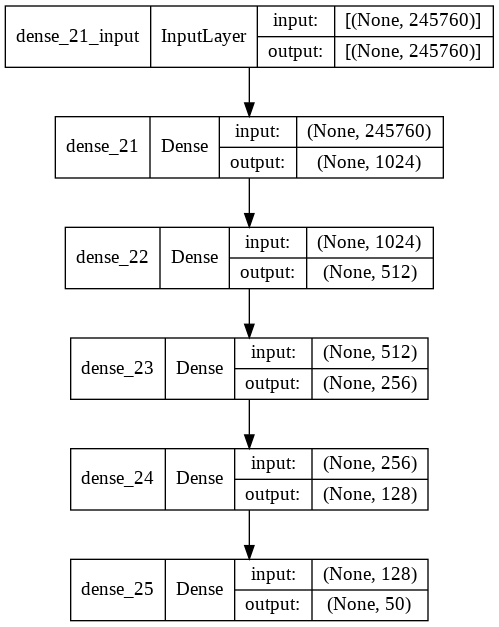

In [ ]:
# Plot the structure of the contructed model.
plot_model(DNN_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [22]:
def compile_train_model(model, x , y , epochs=50, optimizer = 'Adam', validation_split = 0.2 ,shuffle= True, batch_size = 4):
  timestamp=int(time.time())
  
  # Compile
  model.compile(optimizer= optimizer,
                loss = 'categorical_crossentropy',
                metrics=['accuracy'])

  # Train
  start_time = time.time()
  history = model.fit(
    x,
    y,
    epochs=epochs,
    batch_size= batch_size,
    validation_split = validation_split,
    #verbose=0,
    callbacks=[    
        EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)]
  )

  end_time = time.time()
  second_elapsed = round(end_time - start_time)

  print(f'Finished model training in {second_elapsed}s')

  print('Model performance with training set')
  model.evaluate(x, y)

  print('Evaluating model performance with validation set')
  model.evaluate(features_test, labels_test)

  return history, model , second_elapsed

In [ ]:
# # Create an Instance of Early Stopping Callback
# early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# # Compile the model and specify loss function, optimizer and metrics values to the model
# DNN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])



train model


In [ ]:
NUM_THREADS=8
tf.config.threading.set_inter_op_parallelism_threads(NUM_THREADS)
tf.config.threading.set_intra_op_parallelism_threads(NUM_THREADS)
# Start training the model.
DNN_model_training_history, model , second_elapsed = compile_train_model(DNN_model, x = features_train, y = labels_train, batch_size= 128)

Epoch 1/50
32/32 [==============================] - 32s 950ms/step - loss: 70.8103 - accuracy: 0.0225 - val_loss: 15.6719 - val_accuracy: 0.0339
Epoch 2/50
32/32 [==============================] - 28s 875ms/step - loss: 5.9738 - accuracy: 0.0302 - val_loss: 4.0114 - val_accuracy: 0.0309
Epoch 3/50
32/32 [==============================] - 27s 855ms/step - loss: 3.8599 - accuracy: 0.0322 - val_loss: 3.8543 - val_accuracy: 0.0399
Epoch 4/50
32/32 [==============================] - 27s 859ms/step - loss: 3.8400 - accuracy: 0.0302 - val_loss: 3.8199 - val_accuracy: 0.0279
Epoch 5/50
32/32 [==============================] - 27s 842ms/step - loss: 3.8037 - accuracy: 0.0387 - val_loss: 3.8545 - val_accuracy: 0.0709
Epoch 6/50
32/32 [==============================] - 28s 866ms/step - loss: 3.7517 - accuracy: 0.0424 - val_loss: 3.7944 - val_accuracy: 0.0439
Epoch 7/50
32/32 [==============================] - 27s 862ms/step - loss: 3.7189 - accuracy: 0.0614 - val_loss: 3.7323 - val_accuracy: 0.07

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(DNN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

NameError: ignored

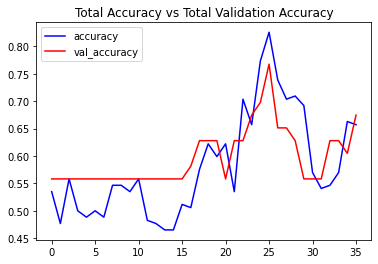

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(DNN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy') 

save model

In [ ]:
# Creating a useful name for our model, incase you're saving multiple models (OPTIONAL)
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
model_name = f'Model___Date_Time_{current_date_time_string}___Loss_
{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Saving your Model
model.save(model_name)

plot model accuracy and loss

In [ ]:
pred_DNN = DNN_model.predict(features_test)

In [ ]:
pred_classes_DNN = np.argmax(pred_DNN, axis = 1)
pred_classes_DNN;

In [ ]:
y_label = np.argmax(labels_test, axis = 1)

In [ ]:
print_validation_report(y_label,pred_classes_DNN)

Classification Report
              precision    recall  f1-score   support

           0       0.70      1.00      0.82        40
           1       1.00      0.47      0.64        32

    accuracy                           0.76        72
   macro avg       0.85      0.73      0.73        72
weighted avg       0.83      0.76      0.74        72

Accuracy Score: 0.7638888888888888
Root Mean Square Error: 0.485912657903775


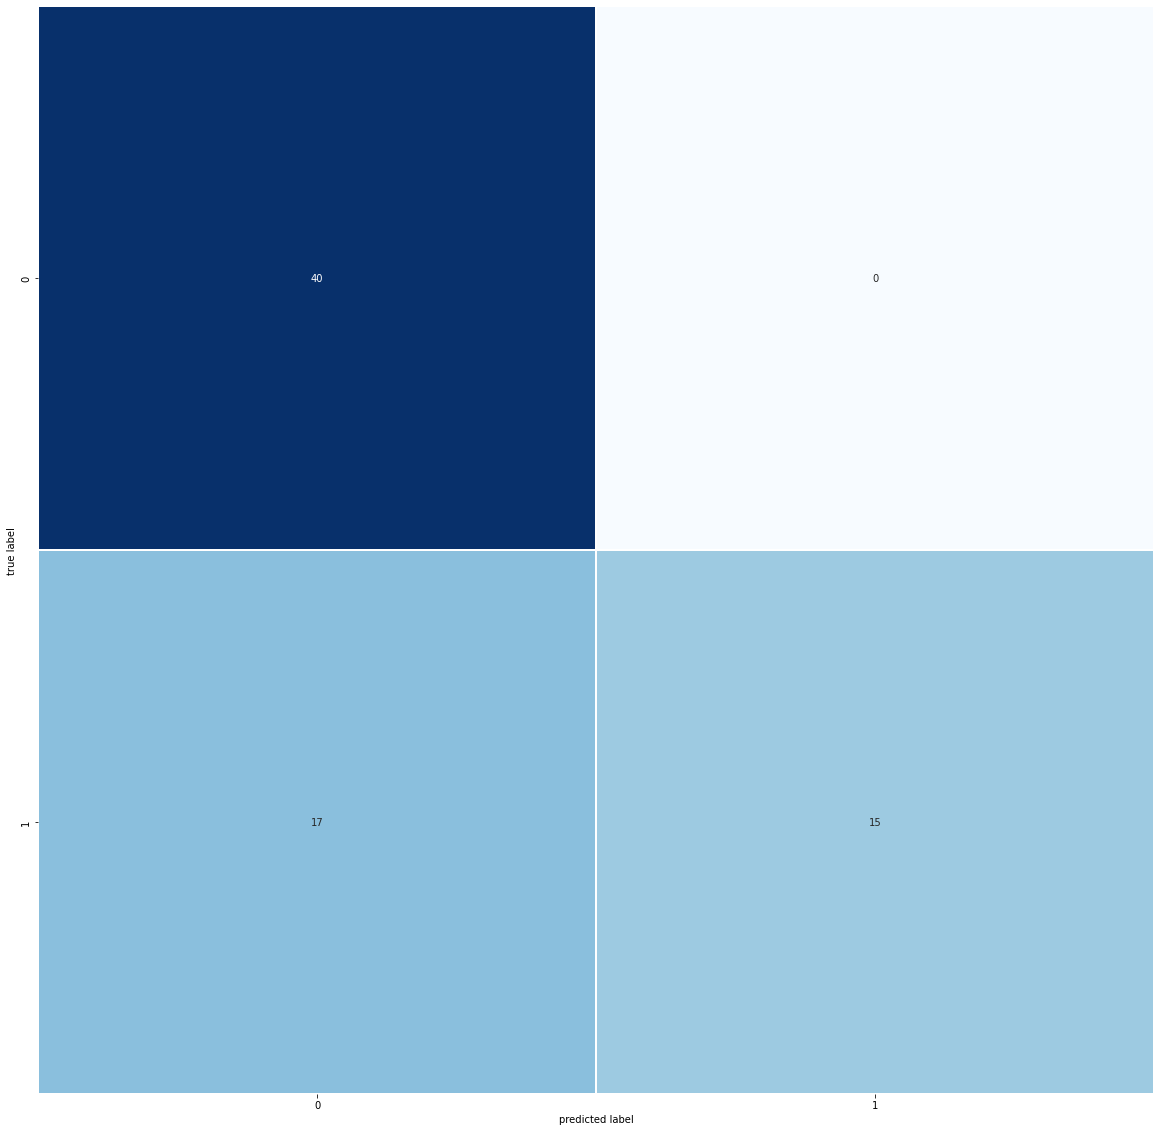

In [ ]:
plot_confusion_matrix(y_label,pred_classes_DNN)

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
gc.collect()

88

### **<font style="color:rgb(134,19,348)">Step 5.1: Construct the Model</font>**

To implement our LRCN architecture, we will use time-distributed **`Conv2D`** layers which will be followed by **`MaxPooling2D`** and **`Dropout`** layers. The feature extracted from the **`Conv2D`** layers will be then flattened using the  **`Flatten`** layer and will be fed to a **`LSTM`** layer. The **`Dense`** layer with softmax activation will then use the output from the **`LSTM`** layer to predict the action being performed.

In [ ]:
def create_CNN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = tf.keras.Sequential( [   
    TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    
   ,(TimeDistributed(MaxPooling2D((4, 4)))) 
    ,(TimeDistributed(Dropout(0.25)))
    
    ,(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    ,(TimeDistributed(MaxPooling2D((4, 4))))
   ,(TimeDistributed(Dropout(0.25)))
    
    ,(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    ,(TimeDistributed(MaxPooling2D((2, 2))))
    ,(TimeDistributed(Dropout(0.25)))
    
    ,(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    ,(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))
                                      
    ,(Flatten())
                                      
    ,Dense(2056)
                                      
   ,Dense(name ='output', units =50, activation = 'softmax')
    ])
    ########################################################################################################################

    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

Now we will utilize the function **`create_LRCN_model()`** created above to construct the required `LRCN` model.

In [ ]:
gc.collect()

9708

In [ ]:
# Construct the required LRCN model.
CNN_model = create_CNN_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_72 (TimeDi  (None, 20, 64, 64, 16)   448       
 stributed)                                                      
                                                                 
 time_distributed_73 (TimeDi  (None, 20, 16, 16, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_74 (TimeDi  (None, 20, 16, 16, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_75 (TimeDi  (None, 20, 16, 16, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_76 (TimeDi  (None, 20, 4, 4, 32)    

#### **<font style="color:rgb(134,19,348)">Check Model’s Structure:</font>**

Now we will use the **`plot_model()`** function to check the structure of the constructed `LRCN` model. As we had checked for the previous model.

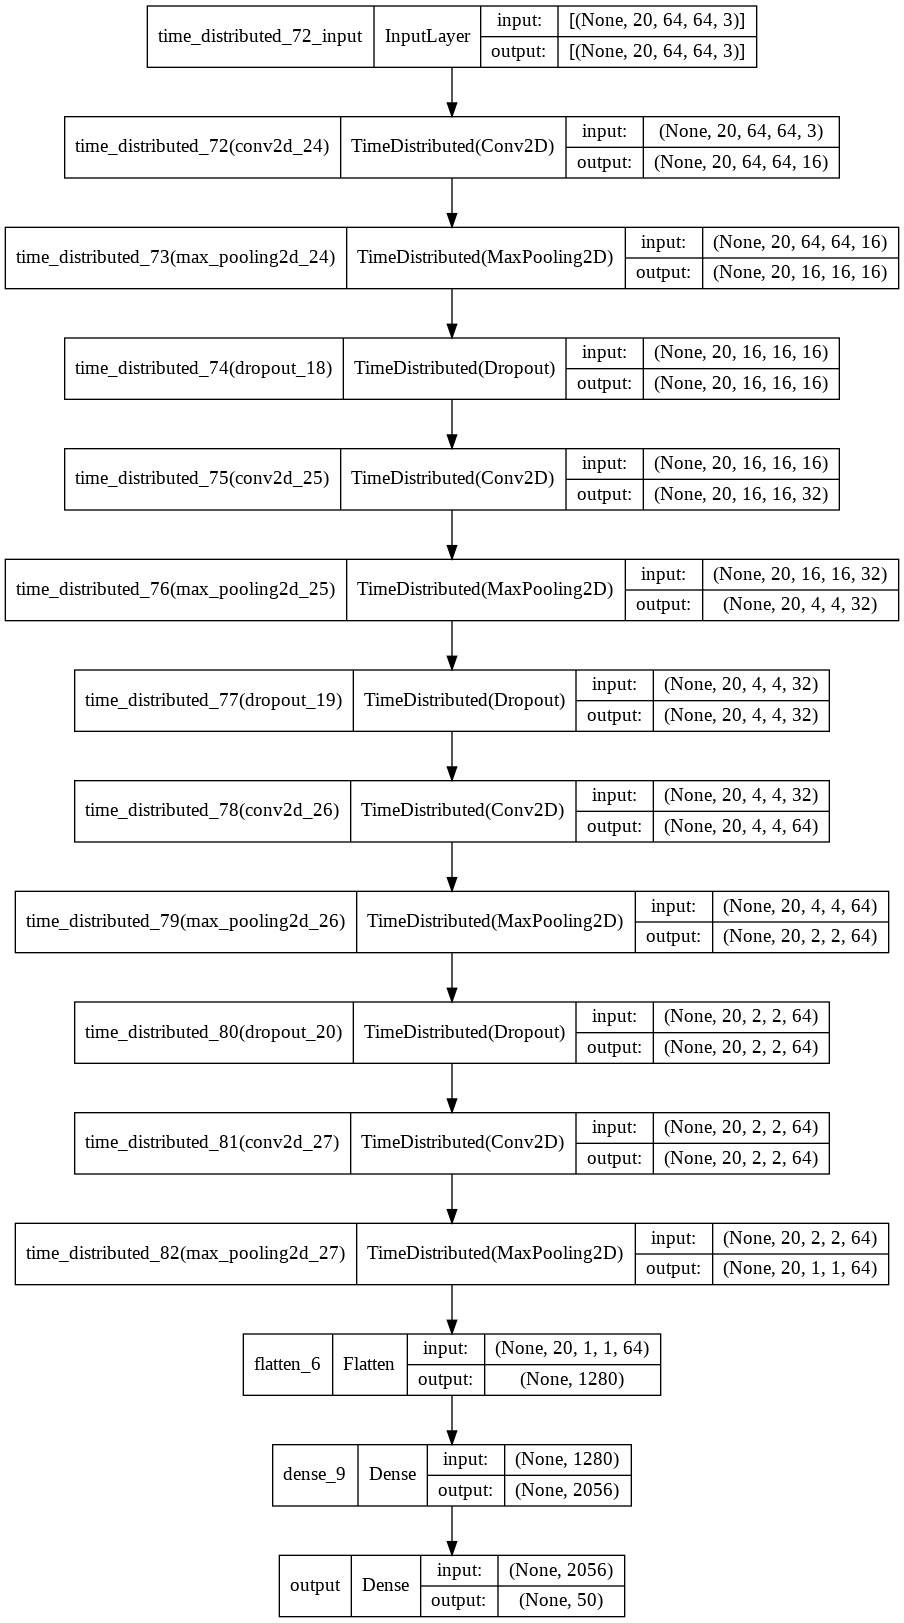

In [ ]:
# Plot the structure of the contructed LRCN model.
plot_model(CNN_model, to_file = 'CNN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

### **<font style="color:rgb(134,19,348)">Step 5.2: Compile & Train the Model</font>**


After checking the structure, we will compile and start training the model.

In [ ]:
# # Create an Instance of Early Stopping Callback.
# early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
# # Compile the model and specify loss function, optimizer and metrics to the model.
# CNN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# # Start training the model.
# CNN_model_training_history = CNN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 1 ,
#                                              shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

#### **<font style="color:rgb(134,19,348)">Evaluating the trained Model</font>**

As done for the previous one, we will evaluate the `LRCN` model on the test set.

In [ ]:
gc.collect()

88

In [ ]:
# Evaluate the trained model.
CNN_model_evaluation_history, model , second_elapsed = compile_train_model(CNN_model, x = features_train, y = labels_train, batch_size= 4)

Epoch 1/50
610/610 [==============================] - 56s 90ms/step - loss: 3.7941 - accuracy: 0.0430 - val_loss: 3.6864 - val_accuracy: 0.0376
Epoch 2/50
610/610 [==============================] - 41s 67ms/step - loss: 3.4721 - accuracy: 0.0861 - val_loss: 3.0572 - val_accuracy: 0.1768
Epoch 3/50
610/610 [==============================] - 41s 68ms/step - loss: 3.0301 - accuracy: 0.1713 - val_loss: 2.9132 - val_accuracy: 0.2308
Epoch 4/50
610/610 [==============================] - 41s 68ms/step - loss: 2.6823 - accuracy: 0.2570 - val_loss: 2.5573 - val_accuracy: 0.2864
Epoch 5/50
610/610 [==============================] - 42s 69ms/step - loss: 2.4037 - accuracy: 0.3287 - val_loss: 2.5196 - val_accuracy: 0.3290
Epoch 6/50
610/610 [==============================] - 42s 69ms/step - loss: 2.1099 - accuracy: 0.3963 - val_loss: 2.2733 - val_accuracy: 0.3944
Epoch 7/50
610/610 [==============================] - 41s 67ms/step - loss: 1.9031 - accuracy: 0.4643 - val_loss: 2.1948 - val_accuracy:

#### **<font style="color:rgb(134,19,348)">Save the Model</font>**

After that, we will save the model for future uses using the same technique we had used for the previous model.

In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = CNN_model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
    
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save the Model.
LRCN_model.save(model_file_name)

### **<font style="color:rgb(134,19,348)">Step 5.3: Plot Model’s Loss & Accuracy Curves</font>**

Now we will utilize the function **`plot_metric()`** we had created above to visualize the training and validation metrics of this model.


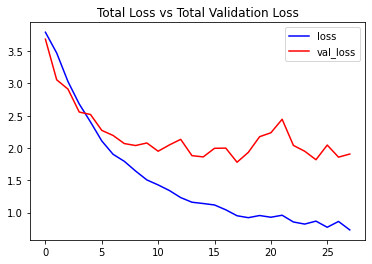

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(CNN_model_evaluation_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

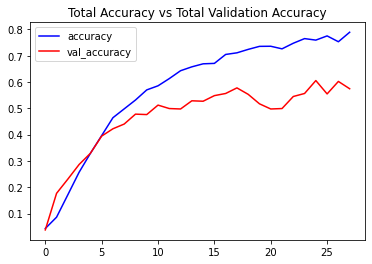

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(CNN_model_evaluation_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [ ]:
pred_CNN = CNN_model.predict(features_test)

In [ ]:
pred_CNN.shape

(1017, 50)

In [ ]:
pred_classes_CNN = np.argmax(pred_CNN, axis = 1)
pred_classes_CNN;

In [ ]:
pred_classes_CNN.shape

(1017,)

In [ ]:
print_validation_report(y_label,pred_classes_CNN)

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.58      0.72        36
           1       0.67      0.46      0.55        13
           2       0.25      0.32      0.28        31
           3       0.96      1.00      0.98        27
           4       0.88      0.96      0.92        23
           5       0.68      0.71      0.69        24
           6       0.95      0.54      0.69        35
           7       0.66      0.90      0.76        30
           8       0.92      0.46      0.62        26
           9       0.80      0.33      0.47        12
          10       0.58      0.68      0.62        22
          11       0.67      0.92      0.77        26
          12       0.26      0.33      0.29        21
          13       1.00      0.56      0.72        34
          14       0.52      0.48      0.50        27
          15       0.86      0.62      0.72        40
          16       0.47      0.70      0.56        10
     

In [ ]:
y_label= np.argmax(labels_test, axis =1)

In [ ]:
labels_test.shape

(1017, 50)

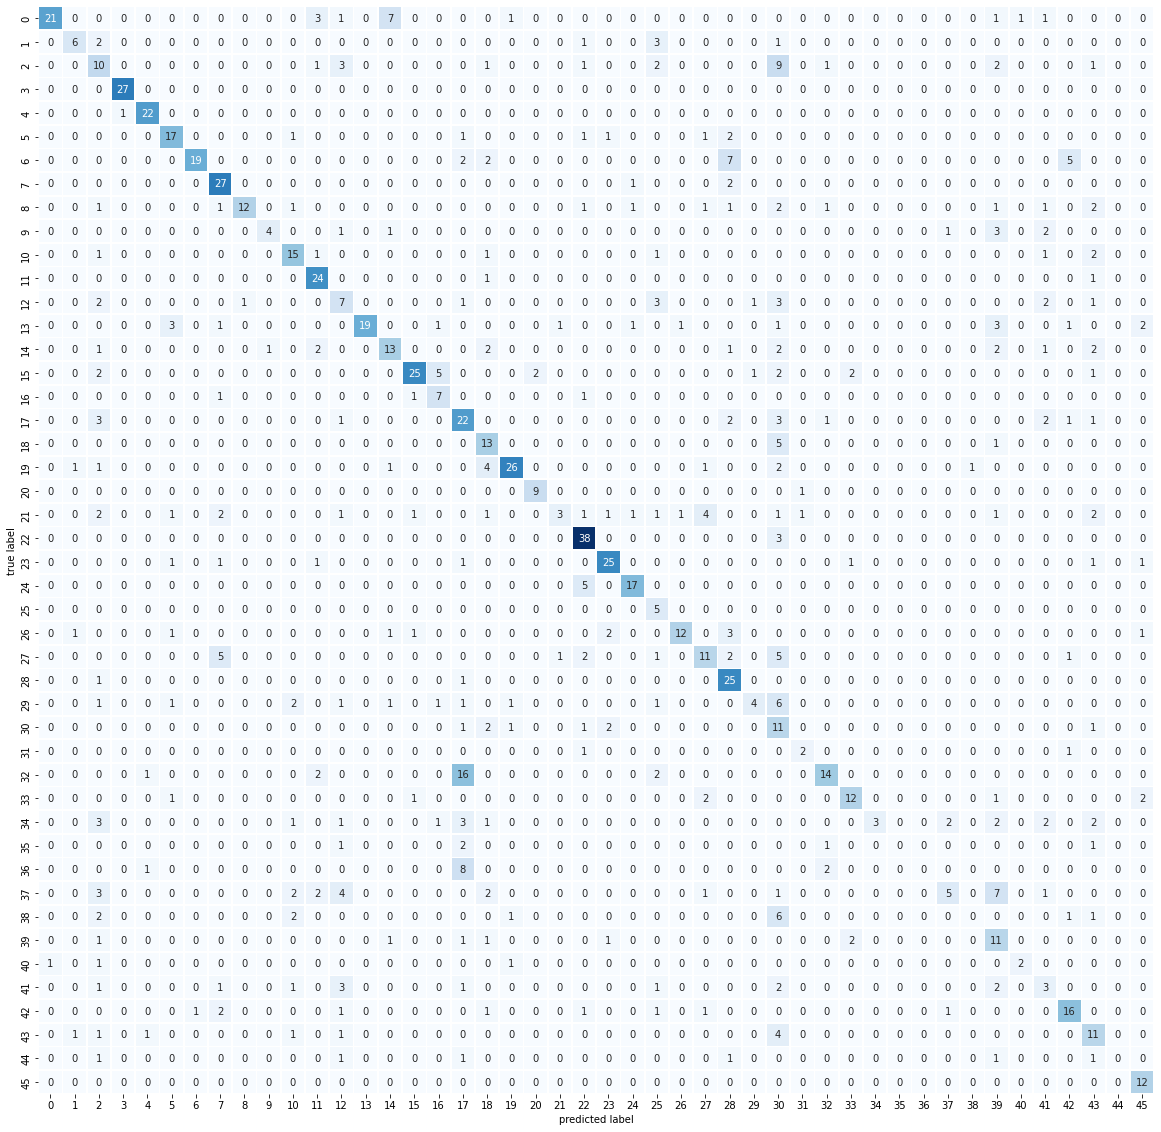

In [ ]:
plot_confusion_matrix(y_label,pred_classes_CNN)

In [ ]:
print_validation_report(y_label,pred_classes_CNN)

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.58      0.72        36
           1       0.67      0.46      0.55        13
           2       0.25      0.32      0.28        31
           3       0.96      1.00      0.98        27
           4       0.88      0.96      0.92        23
           5       0.68      0.71      0.69        24
           6       0.95      0.54      0.69        35
           7       0.66      0.90      0.76        30
           8       0.92      0.46      0.62        26
           9       0.80      0.33      0.47        12
          10       0.58      0.68      0.62        22
          11       0.67      0.92      0.77        26
          12       0.26      0.33      0.29        21
          13       1.00      0.56      0.72        34
          14       0.52      0.48      0.50        27
          15       0.86      0.62      0.72        40
          16       0.47      0.70      0.56        10
     

In [ ]:
print_validation_report_labeled(y_label,pred_classes_LRCN)

Classification Report
                    precision    recall  f1-score   support

             Swing       0.64      0.64      0.64        39
        BenchPress       0.75      1.00      0.86        39
            Diving       0.84      0.91      0.88        35
             Punch       0.86      0.97      0.91        37
    MilitaryParade       0.64      0.53      0.58        30
       ThrowDiscus       0.38      0.38      0.38        24
          Drumming       0.66      0.87      0.75        45
          HulaHoop       0.67      0.70      0.68        23
      JavelinThrow       0.64      0.72      0.68        29
     BaseballPitch       0.92      0.80      0.85        44
      BreastStroke       0.87      1.00      0.93        26
     PlayingViolin       0.71      0.81      0.76        27
         GolfSwing       0.77      0.71      0.74        42
 VolleyballSpiking       0.65      0.58      0.61        26
     JugglingBalls       0.64      0.86      0.73        21
         HorseRac

** Visualize the Data with its Labels for LCRN model**

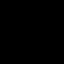

error: ignored

<Figure size 1440x1440 with 0 Axes>

In [ ]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

# Get the names of all classes/categories in UCF50.
all_classes_names = y_label

# Generate a list of 20 random values. The values will be between 0-50, 
# where 50 is the total number of class in the dataset. 
random_range = random.sample(range(len(all_classes_names)), 20)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = list(pred_classes_LRCN)

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    #video_reader = cv2.VideoCapture(features_test[random_index])
    
    # Read the first frame of the video file.
    #_, bgr_frame = video_reader.read()

    # Release the VideoCapture object. 
    #video_reader.release()
    rgb_frame = cv2_imshow(features_test[random_index][4])

    # Convert the frame from BGR into RGB format. 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

In [ ]:
rgb_frame = cv2_imshow(features_test[random_index])

TypeError: ignored

In [ ]:
  _, bgr_frame = video_reader.read()

In [ ]:
type(video_reader)

cv2.VideoCapture

In [ ]:
!pip install -q imageio
!pip install -q opencv-python
!pip install -q git+https://github.com/tensorflow/docs

In [ ]:
# Some modules to display an animation using imageio.
import imageio
from IPython import display
from tensorflow_docs.vis import embed

In [ ]:
def to_gif(images):
    plt.figure(figsize=(50,50))
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=5)
    return embed.embed_file("animation.gif")

In [ ]:
from google.colab.patches import cv2_imshow


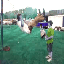

<Figure size 3600x3600 with 0 Axes>

In [ ]:

image = features[0]*255
 
to_gif(image[:20])

In [ ]:
CLASSES_LIST

['BaseballPitch',
 'Basketball',
 'BenchPress',
 'Biking',
 'Billiards',
 'BreastStroke',
 'CleanAndJerk',
 'Diving',
 'Drumming',
 'Fencing',
 'GolfSwing',
 'HighJump',
 'HorseRace',
 'HorseRiding',
 'HulaHoop',
 'JavelinThrow',
 'JugglingBalls',
 'JumpingJack',
 'JumpRope',
 'Kayaking',
 'Lunges',
 'MilitaryParade',
 'Mixing',
 'Nunchucks',
 'PizzaTossing',
 'PlayingGuitar',
 'PlayingPiano',
 'PlayingTabla',
 'PlayingViolin',
 'PoleVault',
 'PommelHorse',
 'PullUps',
 'Punch',
 'PushUps',
 'RockClimbingIndoor',
 'RopeClimbing',
 'Rowing',
 'SalsaSpin',
 'SkateBoarding',
 'Skiing',
 'Skijet',
 'SoccerJuggling',
 'Swing',
 'TaiChi',
 'TennisSwing',
 'ThrowDiscus',
 'TrampolineJumping',
 'VolleyballSpiking',
 'WalkingWithDog',
 'YoYo']

In [17]:
def create_CNN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = tf.keras.Sequential( [   
    TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    
   ,(TimeDistributed(MaxPooling2D((4, 4)))) 
    ,(TimeDistributed(Dropout(0.25)))
    ,BatchNormalization()

    ,(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    ,(TimeDistributed(MaxPooling2D((4, 4))))
   ,(TimeDistributed(Dropout(0.25)))
     ,BatchNormalization()

    ,(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    ,(TimeDistributed(MaxPooling2D((2, 2))))
    ,(TimeDistributed(Dropout(0.25)))
     ,BatchNormalization()
    ,(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    ,(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))
     ,BatchNormalization()
                                      
    ,(Flatten())
                                      
    ,Dense(2056)
                                      
   ,Dense(name ='output', units =50, activation = 'softmax')
    ])
    ########################################################################################################################

    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

Now we will utilize the function **`create_LRCN_model()`** created above to construct the required `LRCN` model.

In [ ]:
tf.keras.backend.clear_session()

In [18]:
# Construct the required LRCN model.
CNN_model = create_CNN_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 64, 64, 16)   448       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 batch_normalization (BatchN  (None, 20, 16, 16, 16)   64        
 ormalization)                                                   
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 16, 16, 32)   4

#### **<font style="color:rgb(134,19,348)">Check Model’s Structure:</font>**

Now we will use the **`plot_model()`** function to check the structure of the constructed `LRCN` model. As we had checked for the previous model.

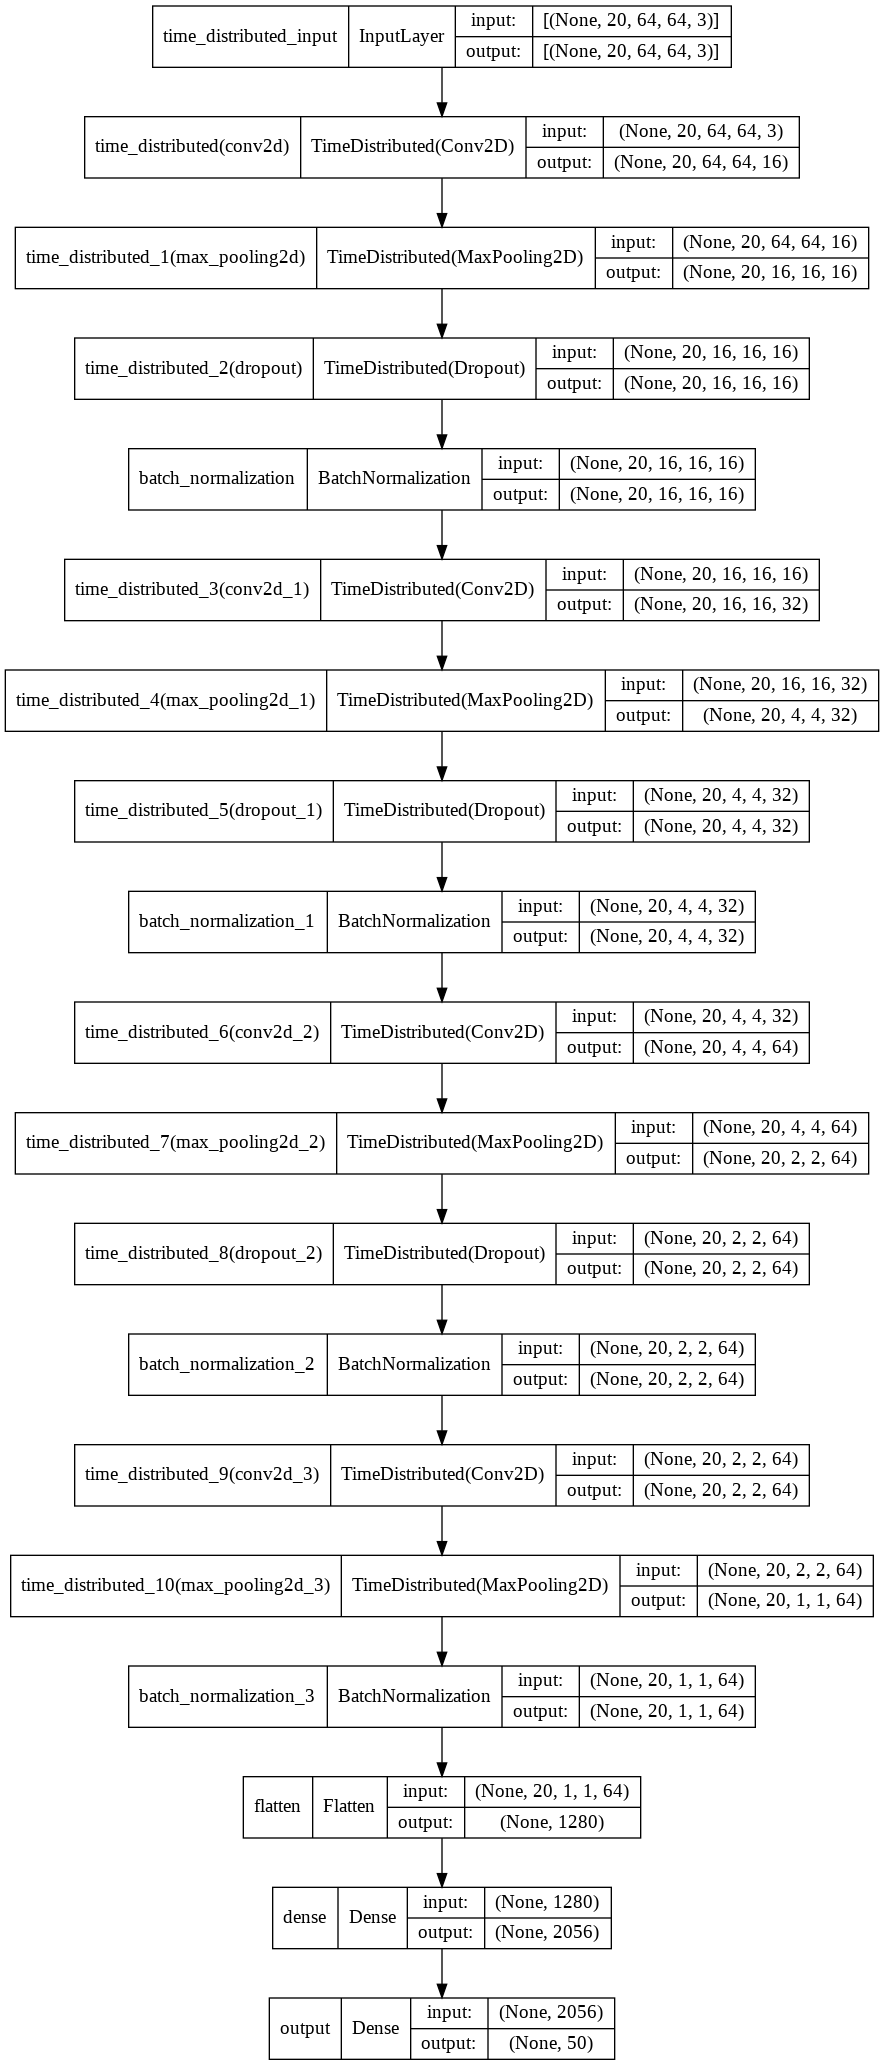

In [19]:
# Plot the structure of the contructed LRCN model.
plot_model(CNN_model, to_file = 'CNN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

### **<font style="color:rgb(134,19,348)">Step 5.2: Compile & Train the Model</font>**


After checking the structure, we will compile and start training the model.

In [20]:
# # Create an Instance of Early Stopping Callback.
# early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
# # Compile the model and specify loss function, optimizer and metrics to the model.
# CNN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# # Start training the model.
# CNN_model_training_history = CNN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 1 ,
#                                              shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

#### **<font style="color:rgb(134,19,348)">Evaluating the trained Model</font>**

As done for the previous one, we will evaluate the `LRCN` model on the test set.

In [23]:
gc.collect()

0

In [24]:
# Evaluate the trained model.
CNN_model_evaluation_history, model , second_elapsed = compile_train_model(CNN_model, x = features_train, y = labels_train, batch_size= 4)

Epoch 1/50
610/610 [==============================] - 14s 8ms/step - loss: 7.7863 - accuracy: 0.0725 - val_loss: 10.4282 - val_accuracy: 0.0426
Epoch 2/50
610/610 [==============================] - 4s 7ms/step - loss: 5.0039 - accuracy: 0.1369 - val_loss: 5.1355 - val_accuracy: 0.1604
Epoch 3/50
610/610 [==============================] - 4s 7ms/step - loss: 3.8490 - accuracy: 0.1643 - val_loss: 4.6274 - val_accuracy: 0.2095
Epoch 4/50
610/610 [==============================] - 4s 6ms/step - loss: 3.2208 - accuracy: 0.2406 - val_loss: 3.3667 - val_accuracy: 0.2930
Epoch 5/50
610/610 [==============================] - 4s 7ms/step - loss: 2.8806 - accuracy: 0.2779 - val_loss: 2.9351 - val_accuracy: 0.3110
Epoch 6/50
610/610 [==============================] - 4s 6ms/step - loss: 2.5221 - accuracy: 0.3463 - val_loss: 3.0116 - val_accuracy: 0.3142
Epoch 7/50
610/610 [==============================] - 4s 6ms/step - loss: 2.2935 - accuracy: 0.3857 - val_loss: 2.6243 - val_accuracy: 0.3993
Epoc

#### **<font style="color:rgb(134,19,348)">Save the Model</font>**

After that, we will save the model for future uses using the same technique we had used for the previous model.

In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = CNN_model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
    
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save the Model.
LRCN_model.save(model_file_name)

### **<font style="color:rgb(134,19,348)">Step 5.3: Plot Model’s Loss & Accuracy Curves</font>**

Now we will utilize the function **`plot_metric()`** we had created above to visualize the training and validation metrics of this model.


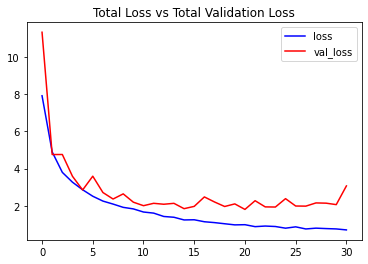

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(CNN_model_evaluation_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

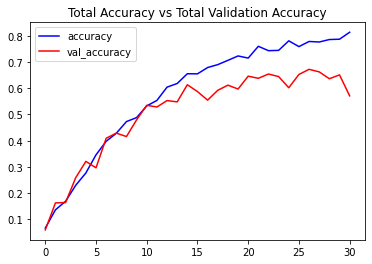

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(CNN_model_evaluation_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [25]:
pred_CNN = CNN_model.predict(features_test)

In [ ]:
pred_CNN.shape

(1017, 50)

In [26]:
pred_classes_CNN = np.argmax(pred_CNN, axis = 1)
pred_classes_CNN;

In [27]:
y_label = np.argmax(labels_test, axis = 1)

In [28]:
print_validation_report(y_label,pred_classes_CNN)

Classification Report
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        36
           1       0.82      0.69      0.75        13
           2       0.67      0.39      0.49        31
           3       1.00      1.00      1.00        27
           4       0.91      0.91      0.91        23
           5       0.84      0.88      0.86        24
           6       0.79      0.97      0.87        35
           7       0.85      0.97      0.91        30
           8       0.69      0.96      0.81        26
           9       0.55      0.92      0.69        12
          10       0.93      0.64      0.76        22
          11       0.79      1.00      0.88        26
          12       0.58      0.52      0.55        21
          13       0.89      0.71      0.79        34
          14       0.71      1.00      0.83        27
          15       0.80      0.82      0.81        40
          16       1.00      0.80      0.89        10
     

In [39]:
import tensorflow as tf
run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)

AttributeError: ignored

In [30]:
from tensorflow.keras import models, layers
from sklearn.manifold import TSNE

In [ ]:
# Extracts the outputs of all layers:
layer_outputs = [layer.output for layer in CNN_model.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs= CNN_model.input, outputs=layer_outputs)

# Get activation values for the last dense layer
activations = activation_model.predict(features_test[:50])
dense_layer_activations = activations[-2]
output_layer_activations = activations[-1]

In [ ]:
activations[-3].shape

In [ ]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne = TSNE(n_components= 5, verbose=2, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(dense_layer_activations)

# Scaling
tsne_results = (tsne_results - tsne_results.min()) / (tsne_results.max() - tsne_results.min())

In [ ]:

cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
scatter = plt.scatter(tsne_results[:,0],tsne_results[:,1], c=y_label[:1000], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=CLASSES_LIST)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        #imagebox = mpl.offsetbox.AnnotationBbox(
            #mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
             #position, bboxprops={"lw": 1})
        #plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()